In [3]:
# Load dataset and gpt2

In [1]:
import sys
sys.path.append("../src/")
%load_ext autoreload
%autoreload 2

import data_utils as du

In [2]:
data = du.get_wiki_data(0, 10)

INFO:absl:No config specified, defaulting to first: wiki40b/en
INFO:absl:Load dataset info from gs://tfds-data/datasets/wiki40b/en/1.3.0
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset wiki40b (gs://tfds-data/datasets/wiki40b/en/1.3.0)
INFO:absl:Constructing tf.data.Dataset for split train[0:10], from gs://tfds-data/datasets/wiki40b/en/1.3.0


In [4]:
data = du.get_wiki_data(0, 100)
paragraphs = []
for d in data:
    paragraphs.extend(du.get_paragraphs(d))

INFO:absl:No config specified, defaulting to first: wiki40b/en
INFO:absl:Load dataset info from gs://tfds-data/datasets/wiki40b/en/1.3.0
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset wiki40b (gs://tfds-data/datasets/wiki40b/en/1.3.0)
INFO:absl:Constructing tf.data.Dataset for split train[0:100], from gs://tfds-data/datasets/wiki40b/en/1.3.0


In [3]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [4]:
paragraphs = [p.replace("\n", " ") for p in paragraphs]

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.eval()
pass

In [36]:
tokenized_paras = []
for para in paragraphs:
    toked = tokenizer.encode(para, return_tensors="pt",)
    if toked.shape[1] >= 512:
        tokenized_paras.append(toked[:,:512])

In [37]:
len(tokenized_paras)

1246

In [38]:
x = model(tokenized_paras[0], labels=tokenized_paras[0], return_dict=True)

In [39]:
x.logits.shape

torch.Size([1, 512, 50257])

In [42]:
import torch

In [50]:
with torch.no_grad():
    shift_logits = x.logits[..., :-1, :].contiguous()
    shift_labels = tokenized_paras[0][..., 1:].contiguous()
    # Flatten the tokens
    loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

In [52]:
loss.shape

torch.Size([511])

In [100]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

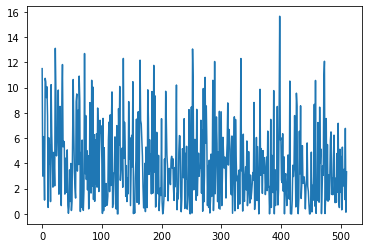

In [51]:
plt.plot(loss)

In [62]:
%%time 
losses = []
loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
for i, para in enumerate(tokenized_paras):
    with torch.no_grad():
        out = model(para, labels=para, return_dict=True)
        shift_logits = out.logits[..., :-1, :].contiguous()
        shift_labels = para[..., 1:].contiguous()
        # Flatten the tokens
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        losses.append(loss)
    if i > 100:
        break

CPU times: user 3min 12s, sys: 18.2 s, total: 3min 30s
Wall time: 2min 51s


In [63]:
mean_losses = [l.numpy() for  l in losses]
mean_losses = np.mean(mean_losses, axis=0)
mean_losses.shape

(511,)

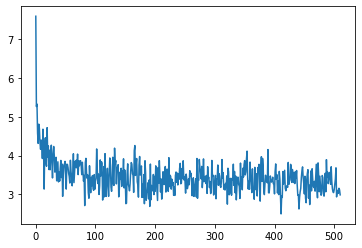

In [64]:
plt.plot(mean_losses)

In [102]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

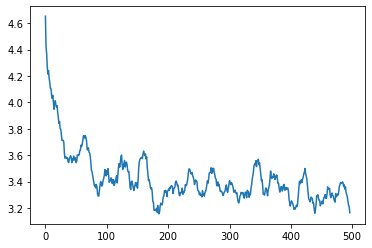

In [68]:
plt.plot(moving_average(mean_losses, 15))

In [69]:
smoothed = []
for i in range(len(mean_losses) - 10):
    smoothed.append(np.mean(mean_losses[i:i+10]))

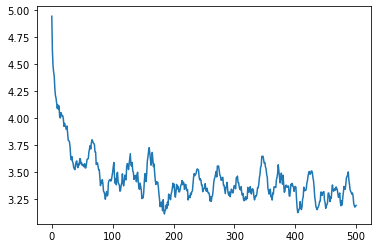

In [70]:
plt.plot(smoothed)

In [76]:
from transformers import ReformerTokenizer, ReformerModel

reformer_tokenizer = ReformerTokenizer.from_pretrained('google/reformer-crime-and-punishment')
reformer_model = ReformerModel.from_pretrained('google/reformer-crime-and-punishment')

Some weights of ReformerModel were not initialized from the model checkpoint at google/reformer-crime-and-punishment and are newly initialized: ['reformer.encoder.layers.0.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.0.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.1.attention.self_attention.self_mask_value_float16', 'reformer.encoder.layers.1.attention.self_attention.self_mask_value_float32', 'reformer.encoder.layers.1.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.1.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.2.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.2.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.3.attention.self_attention.self_mask_value_float16', 'reformer.encoder.layers.3.attention.self_attention.self_mask_value_float32', 'reformer.encoder.layers.3.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.3.atten

/Users/daniter/anaconda3/envs/iterdiscoher/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [110]:
from transformers import XLNetTokenizer, XLNetLMHeadModel

In [111]:
xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
xlnet_model = XLNetLMHeadModel.from_pretrained('xlnet-base-cased')

In [36]:
import torch
import numpy as  np

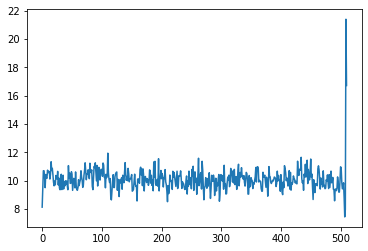

In [39]:
xlnet_tokenized_paras = []
for para in paragraphs:
    toked = xlnet_tokenizer(para, return_tensors="pt", truncation=True, max_length=512)
    if toked['input_ids'].shape[1] >= 512:
        xlnet_tokenized_paras.append(toked)
        if len(xlnet_tokenized_paras) > 100:
            break

losses = []
loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
for i, para in enumerate(xlnet_tokenized_paras):
    with torch.no_grad():
        out = xlnet_model(**para, labels=para['input_ids'], return_dict=True)
        shift_logits = out.logits[..., :-1, :].contiguous()
        shift_labels = para['input_ids'][..., 1:].contiguous()
        # Flatten the tokens
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        losses.append(loss)
    if i > 50:
        break
        
mean_losses = [l.numpy() for  l in losses]
mean_losses = np.mean(mean_losses, axis=0)
plt.plot(mean_losses)

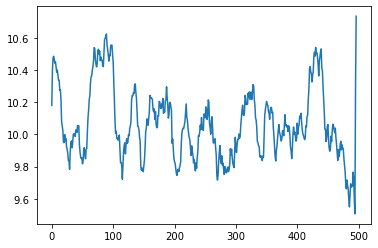

In [42]:
plt.plot(moving_average(mean_losses, 15))

In [56]:
from transformers import OpenAIGPTTokenizer, OpenAIGPTLMHeadModel

gpt_tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
gpt_model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
gpt_model.eval()
pass

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
Some weights of OpenAIGPTLMHeadModel were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
tokenized_paras = []
for para in paragraphs:
    toked = gpt_tokenizer.encode(para, return_tensors="pt",)
    if toked.shape[1] >= 512:
        tokenized_paras.append(toked[:,:512])
    if len(tokenized_paras) > 100:
        break
        
losses = []
loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
for i, para in enumerate(tokenized_paras):
    with torch.no_grad():
        out = gpt_model(para, labels=para, return_dict=True)
        shift_logits = out.logits[..., :-1, :].contiguous()
        shift_labels = para[..., 1:].contiguous()
        # Flatten the tokens
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        losses.append(loss)
    if i > 50:
        break
        
mean_losses = [l.numpy() for  l in losses]
mean_losses = np.mean(mean_losses, axis=0)


Token indices sequence length is longer than the specified maximum sequence length for this model (830 > 512). Running this sequence through the model will result in indexing errors


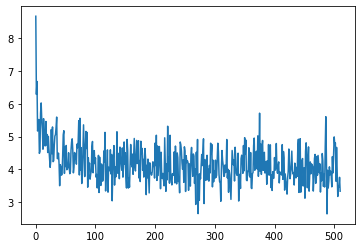

In [58]:
plt.plot(mean_losses)

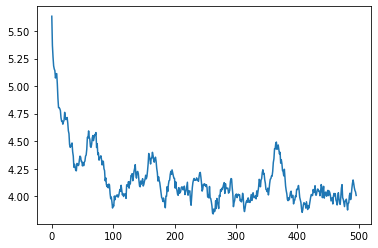

In [59]:
plt.plot(moving_average(mean_losses, 15))

In [70]:
loss_fct = torch.nn.CrossEntropyLoss(reduction="none")


In [71]:
from transformers import TransfoXLTokenizer, TransfoXLLMHeadModel

txl_tokenizer = TransfoXLTokenizer.from_pretrained('transfo-xl-wt103')
txl_model = TransfoXLLMHeadModel.from_pretrained('transfo-xl-wt103')
txl_model.eval()

tokenized_paras = []
for para in paragraphs:
    toked = txl_tokenizer.encode(para, return_tensors="pt",)
    if toked.shape[1] >= 512:
        tokenized_paras.append(toked[:,:512])
    if len(tokenized_paras) > 100:
        break
        
print("Done tokenizing")
        
losses = []
loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
for i, para in enumerate(tokenized_paras):
    print(i)
    with torch.no_grad():
        out = txl_model(para, labels=para, return_dict=True)
        losses.append(out.losses)
    if i > 5:
        break
        
mean_losses = [l.numpy() for  l in losses]
mean_losses = np.mean(mean_losses, axis=0)


Done tokenizing
0


/Users/daniter/anaconda3/envs/iterdiscoher/lib/python3.7/site-packages/transformers-4.2.2-py3.8.egg/transformers/models/transfo_xl/modeling_transfo_xl.py:445: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370126481/work/torch/csrc/utils/python_arg_parser.cpp:882.)


1
2


KeyboardInterrupt: 

In [65]:
txl_tokenizer.encode(para, return_tensors="pt",)

tensor([[   24,    90,    25,   860,    17,     1,  5146,   532,   129,   111,
          4736,    15,    77,   195,   324,     3,  5758,   240,     1,   300,
           219,     2,    19,    24,  1412,  5758,    14,   109,   735,     3,
            24,    11,  5758,    14,   316,  7750,     7,   286,  5155,   165,
           681,  4894,     3,    89,   437,   184,   286,     2,    30,    11,
           225,    20,  1356, 69779,  7395,     7,  5758,    14,  1108,   500,
            12,   435,  3585,    17,     1,   286,  5155,   165,   681,     3,
            89,   318,   195,   286,     2,    24,   593,    25,    40,   735,
             7,     1,  5155,   165,   681,     2,   111,   777,     7,     8,
          1221,  1373,   300,     2,    34,  5758,   240,   146,     3,    33,
             1,   159,   300,     2,    24,  7144,    32,     8,  9330,  2382,
            19, 19948, 29677,     2,    52,    11,   594,     7,  6776,     5,
          9262,    39, 29677,  2624,    16,    69,  

In [64]:
toked.shape

torch.Size([1, 156])

In [66]:
toked[:,:512]

tensor([[   24,    90,    25,   860,    17,     1,  5146,   532,   129,   111,
          4736,    15,    77,   195,   324,     3,  5758,   240,     1,   300,
           219,     2,    19,    24,  1412,  5758,    14,   109,   735,     3,
            24,    11,  5758,    14,   316,  7750,     7,   286,  5155,   165,
           681,  4894,     3,    89,   437,   184,   286,     2,    30,    11,
           225,    20,  1356, 69779,  7395,     7,  5758,    14,  1108,   500,
            12,   435,  3585,    17,     1,   286,  5155,   165,   681,     3,
            89,   318,   195,   286,     2,    24,   593,    25,    40,   735,
             7,     1,  5155,   165,   681,     2,   111,   777,     7,     8,
          1221,  1373,   300,     2,    34,  5758,   240,   146,     3,    33,
             1,   159,   300,     2,    24,  7144,    32,     8,  9330,  2382,
            19, 19948, 29677,     2,    52,    11,   594,     7,  6776,     5,
          9262,    39, 29677,  2624,    16,    69,  

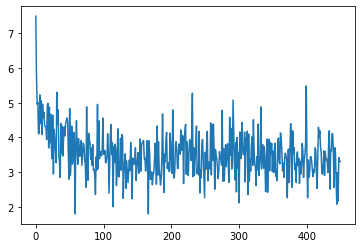

In [80]:
plt.plot(mean_losses.ravel()[:450])

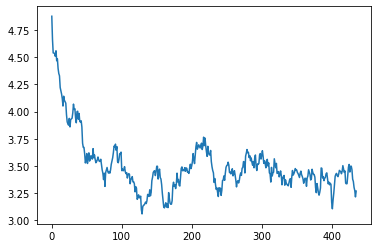

In [79]:
plt.plot(moving_average(mean_losses.ravel()[:450], 15))

In [25]:
out = xlnet_model(**para, labels=para['input_ids'], return_dict=True)

In [26]:
out.keys()

odict_keys(['last_hidden_state', 'mems'])

In [29]:
out = xlnet_model(input_ids=para['input_ids'], token_type_ids=para['token_type_ids'],
                  attention_mask=para['attention_mask'], labels=para['input_ids'], return_dict=True)

In [28]:
para.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [30]:
out.keys()

odict_keys(['last_hidden_state', 'mems'])

In [29]:
import numpy as np

In [89]:
test_data = []
with open("../results/results-xlnet.npy", "rb") as f:
    while True:
        try:
            test_data.append(np.load(f,allow_pickle=True))
        except OSError as e:
            break

In [90]:
test_data[4].shape

(2044,)

In [91]:
len(test_data)

6

In [92]:
test_data[2]

array([ 6.2104597, 11.375074 , 16.117828 , ..., 12.61951  , 17.23285  ,
       14.436523 ], dtype=float32)

(511,)
(511,)
(511,)


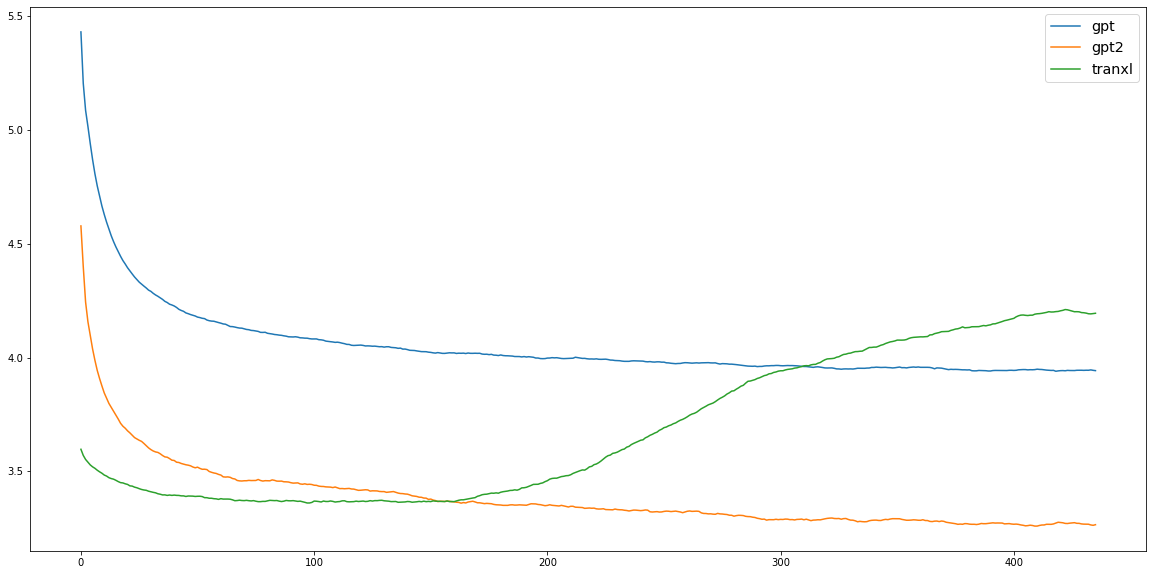

In [161]:
names = ["gpt" ,"gpt2","tranxl"]# ,"xlnet"]
plt.figure(figsize=(20,10))

for name in names:
    test_data = []
    with open("../results/remote_results_test/results-%s.npy" % name, "rb") as f:
        while True:
            try:
                test_data.append(np.load(f,allow_pickle=True))
            except OSError as e:
                break
    shaped_data = []
    for data in test_data:
        shaped_data.append(data.reshape(-1, 511))
    shaped_data = np.concatenate(shaped_data)
    mean_data = np.mean(shaped_data, axis=0)
    print(mean_data.shape)
    plt.plot(moving_average(mean_data[:450], 15), label=name)
plt.legend(fontsize="x-large")



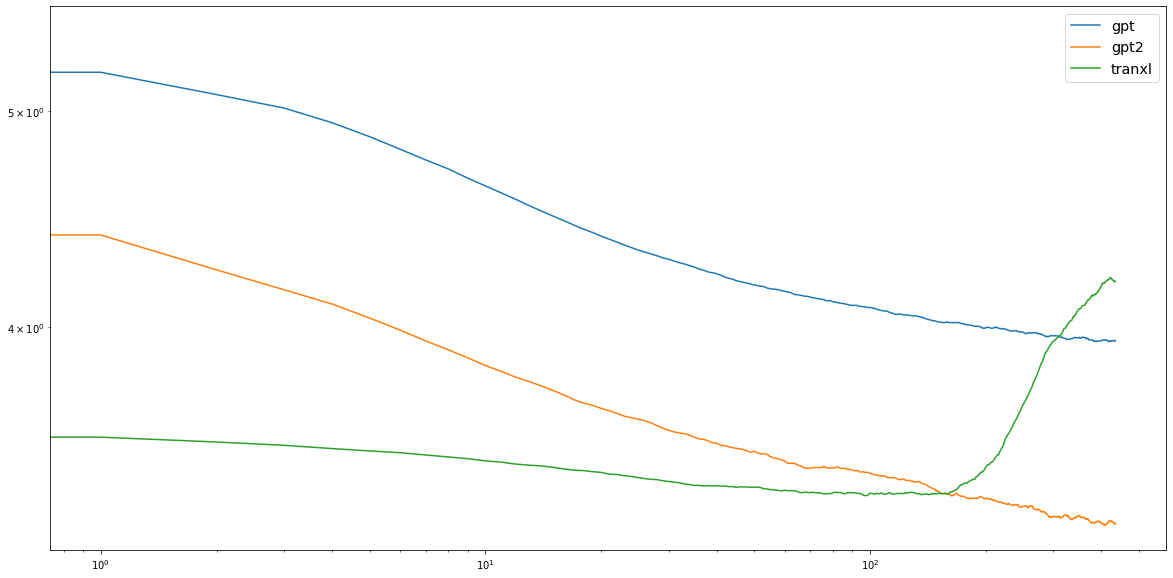

In [163]:
names = ["gpt" ,"gpt2","tranxl"]# ,"xlnet"]
plt.figure(figsize=(20,10))
plt.yscale('log')
plt.xscale('log')

all_avg_data = {}

for name in names:
    test_data = []
    with open("../results/remote_results_test/results-%s.npy" % name, "rb") as f:
        while True:
            try:
                test_data.append(np.load(f,allow_pickle=True))
            except OSError as e:
                break
    shaped_data = []
    for data in test_data:
        shaped_data.append(data.reshape(-1, 511))
    shaped_data = np.concatenate(shaped_data)
    mean_data = np.mean(shaped_data, axis=0)
    all_avg_data[name] = moving_average(mean_data[:450], 15)
    plt.plot(moving_average(mean_data[:450], 15), label=name)
plt.legend(fontsize="x-large")



In [159]:
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a*np.power(x, b)

for name in names:
    y_data = all_avg_data[name]
    x_data = list(range(len(y_data)))

    pars, cov = curve_fit(f=power_law, xdata=x_data, ydata=y_data)
    print(name)
    print(pars) 
    print(cov)

gpt
[4.02109375e+00 2.62876722e-09]
[[ 1.66701085e-03 -7.13152141e-05]
 [-7.13152141e-05  3.52623906e-06]]
gpt2
[3.35833508e+00 3.90098507e-09]
[[ 9.55410072e-04 -4.58486541e-05]
 [-4.58486541e-05  2.65304696e-06]]
tranxl
[2.60815412 0.06740707]
[[ 3.46697551e-03 -2.48763101e-04]
 [-2.48763101e-04  1.83478559e-05]]


/Users/daniter/anaconda3/envs/iterdiscoher/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


In [149]:
pars

array([3.35833508e+00, 3.90098507e-09])

In [150]:
cov

array([[ 9.55410072e-04, -4.58486541e-05],
       [-4.58486541e-05,  2.65304696e-06]])